In [1]:
# Core
import numpy as np
import pandas as pd

# Modeling
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Colab utilities
from google.colab import files

sns.set(style="whitegrid", context="notebook")
print("Ready.")


Ready.


In [9]:
# Upload a CSV (use the dialog)
uploaded = files.upload()  # pick your_file.csv in the dialog

# Replace with the actual uploaded filename if different
df = pd.read_csv(next(iter(uploaded.keys())))
df.head()


Saving Mall_Customers.csv to Mall_Customers.csv


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [11]:
# Keep only numeric columns for K-means
num_df = df.select_dtypes(include=[np.number]).copy()

# Optional: if specific columns are desired, uncomment and list them
# num_df = df[["feature1","feature2","feature3"]].copy()

# Basic missing-value handling
num_df = num_df.dropna()  # or use imputation if preferred

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(num_df.values)

X.shape


(200, 4)

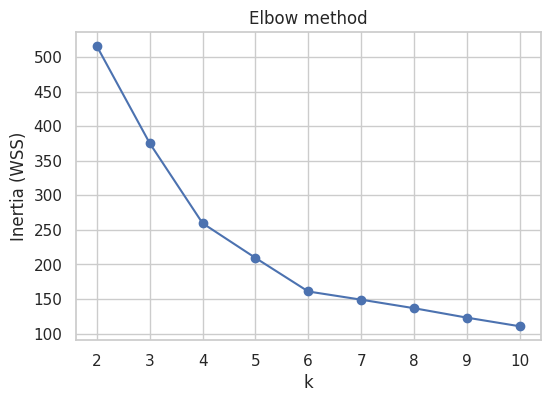

In [12]:
inertias = []
k_range = range(2, 11)  # adjust as needed

for k in k_range:
    km = KMeans(n_clusters=k, n_init="auto", random_state=42)
    km.fit(X)
    inertias.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(list(k_range), inertias, marker="o")
plt.title("Elbow method")
plt.xlabel("k")
plt.ylabel("Inertia (WSS)")
plt.show()


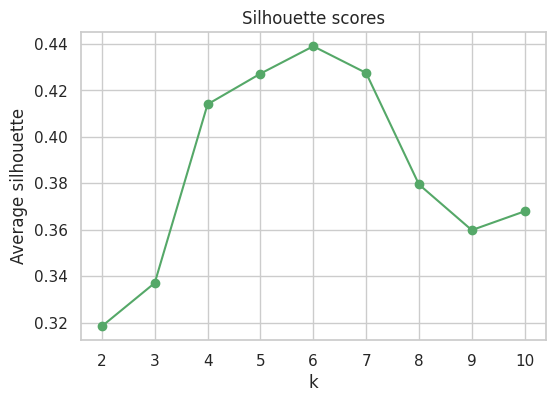

(6, np.float64(0.4390404164555763))

In [13]:
sil_scores = []
for k in k_range:
    km = KMeans(n_clusters=k, n_init="auto", random_state=42).fit(X)
    labels = km.labels_
    sil = silhouette_score(X, labels)
    sil_scores.append(sil)

plt.figure(figsize=(6,4))
plt.plot(list(k_range), sil_scores, "go-")
plt.title("Silhouette scores")
plt.xlabel("k")
plt.ylabel("Average silhouette")
plt.show()

best_k = k_range[int(np.argmax(sil_scores))]
best_k, max(sil_scores)


In [14]:
k = best_k  # or set manually, e.g., k = 4
kmeans = KMeans(n_clusters=k, n_init="auto", random_state=42)
kmeans.fit(X)

labels = kmeans.labels_
centers_scaled = kmeans.cluster_centers_
inertia = kmeans.inertia_

print("k =", k, "inertia =", inertia)
np.unique(labels, return_counts=True)


k = 6 inertia = 160.97567568819875


(array([0, 1, 2, 3, 4, 5], dtype=int32), array([44, 39, 24, 35, 21, 37]))

In [15]:
clustered = num_df.copy()
clustered["cluster"] = labels

# Summary by cluster
summary = clustered.groupby("cluster").agg(["mean","median","std","min","max"])
summary.head()


CustomerID                                    Age                    \
               mean median        std  min  max       mean median        std   
cluster                                                                        
0         82.022727   80.5  22.207781   41  120  56.340909   54.0   8.550651   
1        162.000000  162.0  22.803509  124  200  32.692308   32.0   3.728650   
2         23.041667   23.0  14.072728    1   46  25.250000   23.5   5.326309   
3        164.428571  165.0  21.351795  127  199  41.685714   43.0  10.897305   
4         23.190476   23.0  12.726425    3   45  45.523810   46.0  11.766984   

                Annual Income (k$)                             \
        min max               mean median        std min  max   
cluster                                                         
0        43  70          53.704545   54.0   8.239382  38   67   
1        27  40          86.538462   79.0  16.312485  69  137   
2        18  35          25.833333   24.5   8.057762  15   39   
3        19  59          88.228571   85.0  16.367266  71  137   
4        20  67          26.285714   25.0   7.437357  16   39   

        Spending Score (1-100)                            
                          mean median        std min max  
cluster                                                   
0                    49.386364   49.0   5.993081  35  60  
1                    82.128205   83.0   9.364489  63  97  
2                    76.916667   76.5  13.416138  39  99  
3                    17.285714   16.0  10.211215   1  39  
4                    19.380952   15.0  12.555780   3  40

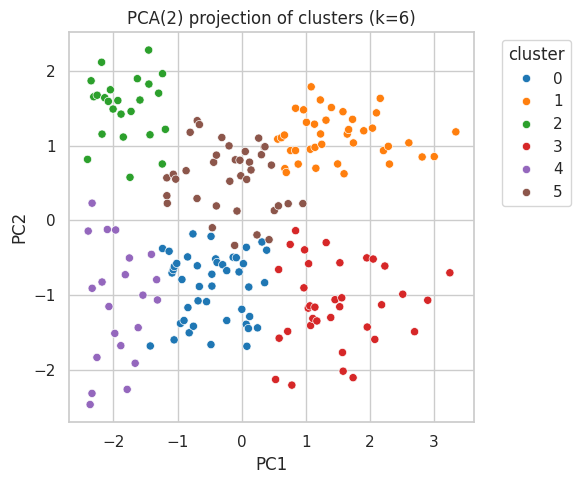

In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
X2 = pca.fit_transform(X)

plt.figure(figsize=(6,5))
sns.scatterplot(x=X2[:,0], y=X2[:,1], hue=labels, palette="tab10", s=35)
plt.title(f"PCA(2) projection of clusters (k={k})")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="cluster", bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()
plt.show()


In [17]:
final_sil = silhouette_score(X, labels)
print("Silhouette (k =", k, "):", round(final_sil, 4))


Silhouette (k = 6 ): 0.439


In [18]:
# Align by index after earlier dropna
df_with_clusters = df.loc[num_df.index].copy()
df_with_clusters["cluster"] = labels

# Save and download
out_name = f"clustered_k{k}.csv"
df_with_clusters.to_csv(out_name, index=False)
files.download(out_name)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>